# Sentiment Analysis

In this notebook, we will investigate the sentiment visible in politicians' tweets. We will perform two methods: a lexicon-based approach using VADER [1] and a supervised approach using the most recent version of the RoBERTa-base model [2].

## 1. Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import tqdm
import torch

from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from wordcloud import WordCloud


## 2. Reading data

In [2]:
df = pd.read_parquet('cleaned_data/df_combined.parquet')
nltk.download('vader_lexicon')
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mateuszpliszka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,id,possibly_sensitive,in_reply_to_user_id,created_at,referenced_tweets,edit_controls,text,edit_history_tweet_ids,reply_settings,author_id,...,links,hashtags,retweet_count,reply_count,like_count,quote_count,impression_count,text_clean_en,text_clean_en_demojized,name
0,1846267743022330112,False,509272614.0,2024-10-15 19:11:46+00:00,"[{'id': '1846155881169182787', 'type': 'replie...",{'editable_until': '2024-10-15 20:11:46+00:00'...,"@Dariusz_Jonski ""Ani kroku wstecz!"" - w przód ...",[1846267743022330183],everyone,1.187749e+18,...,[],[],0,1,13,0,219,"""Not a step back!"" - you haven't put any forw...","""Not a step back!"" - you haven't put any forw...",Włodzimierz Skalik
1,1846264777347117568,False,NaN,2024-10-15 18:59:59+00:00,None,{'editable_until': '2024-10-15 19:59:59+00:00'...,Właśnie zadzwonił do mnie nieznany numer. Już ...,[1846264777347117471],everyone,1.187749e+18,...,[],[],28,9,418,0,6449,An unknown number just called me. I thought it...,An unknown number just called me. I thought it...,Włodzimierz Skalik
2,1846262693394588160,False,955239446.0,2024-10-15 18:51:42+00:00,"[{'id': '1846127632112369787', 'type': 'replie...",{'editable_until': '2024-10-15 19:51:42+00:00'...,"@KosiniakKamysz Czy ""jeszcze cięższa praca"" pr...",[1846262693394588154],everyone,1.187749e+18,...,[],[],4,1,38,0,443,"Will ""even harder work"" translate into the fu...","Will ""even harder work"" translate into the fu...",Włodzimierz Skalik
3,1846261341327446272,False,NaN,2024-10-15 18:46:20+00:00,"[{'id': '1846159669573689602', 'type': 'quoted'}]",{'editable_until': '2024-10-15 19:46:20+00:00'...,Polecam się zapoznać z treścią konferencji 👇 ...,[1846261341327446163],everyone,1.187749e+18,...,[https://t.co/U7LAeL2cqP],[],9,2,48,0,687,I recommend reading the content of the confere...,I recommend reading the content of the confere...,Włodzimierz Skalik
4,1846104865829015552,False,NaN,2024-10-15 08:24:33+00:00,None,{'editable_until': '2024-10-15 09:24:33+00:00'...,❌ Kilka dni temu zagłosowałem za odwołaniem K...,[1846104865829015639],everyone,1.187749e+18,...,"[https://t.co/JQAQMEKjEs, https://t.co/4qtpUJO...",[],30,0,141,0,3354,"❌ A few days ago, I voted to dismiss Krzyszto...",":cross_mark: A few days ago, I voted to dismi...",Włodzimierz Skalik


## 3. Additional cleaning data

In [3]:
na_count = df['text_clean_en'].isna().sum()
print(f"Number of NaN values in 'text_clean_en': {na_count}. Total number of rows: {len(df)}")

Number of NaN values in 'text_clean_en': 204. Total number of rows: 11457


In [4]:
df_no_na = df[df['text_clean_en'].notna()]

To perform sentiment analysis on tweet texts, we filtered out all tweets without any text. There were 204 such tweets, leaving us with 11,253 tweets after filtering.

## 4. Lexicon based Sentiment Analysis (VADER)

In [5]:
sia = SentimentIntensityAnalyzer()
res = {}

for i, row in tqdm.tqdm(df_no_na.iterrows(), total=len(df_no_na)):
    text = row['text_clean_en_demojized']
    myID = row['id']
    res[myID] = sia.polarity_scores(text)

vader_res = pd.DataFrame.from_dict(res, orient='index').reset_index()
vader_res.rename(columns={'index': 'id', 'neg': 'neg_vader', 'neu': 'neu_vader', 'pos': 'pos_vader', 'compound': 'compound_vader'}, inplace=True)
print("Average sentiment scores:")
print(vader_res.iloc[:, 1:5].mean())
df_no_na = df_no_na.merge(vader_res, on='id', how='left')
df_no_na[["username", "name", "text_clean_en", "neg_vader", "neu_vader", "pos_vader", "compound_vader"]].head()

100%|██████████| 11253/11253 [00:01<00:00, 6541.88it/s]

Average sentiment scores:
neg_vader         0.068163
neu_vader         0.781242
pos_vader         0.150505
compound_vader    0.166250
dtype: float64


,username,name,text_clean_en,neg_vader,neu_vader,pos_vader,compound_vader
0,Wlodek_Skalik,Włodzimierz Skalik,"""Not a step back!"" - you haven't put any forw...",0.000,1.000,0.000,0.0000
1,Wlodek_Skalik,Włodzimierz Skalik,An unknown number just called me. I thought it...,0.000,0.949,0.051,0.0772
2,Wlodek_Skalik,Włodzimierz Skalik,"Will ""even harder work"" translate into the fu...",0.000,0.867,0.133,0.3818
3,Wlodek_Skalik,Włodzimierz Skalik,I recommend reading the content of the confere...,0.000,0.737,0.263,0.3612
4,Wlodek_Skalik,Włodzimierz Skalik,"❌ A few days ago, I voted to dismiss Krzyszto...",0.161,0.803,0.036,-0.6705


### 4.1. Top 5 most negative politicians

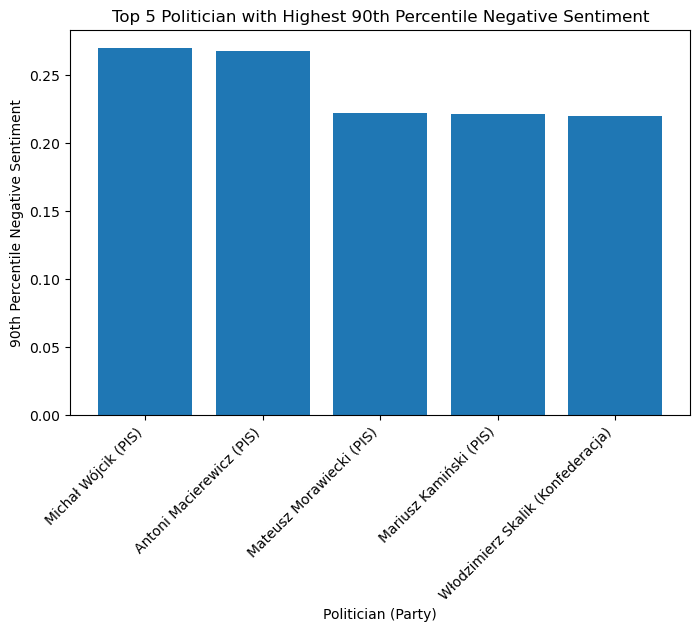

In [6]:
percentile_90_neg = df_no_na.groupby('username')['neg_vader'].quantile(0.90).reset_index()

top5_neg_sentiment = percentile_90_neg.sort_values(by='neg_vader', ascending=False).head(5)
top5_neg_sentiment = top5_neg_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_neg_sentiment['name_with_party'] = top5_neg_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_neg_sentiment['name_with_party'], top5_neg_sentiment["neg_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Negative Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Negative Sentiment')
plt.show()

According to VADER analysis, the top 5 politicians with the highest 90th percentile of negative sentiment in their tweets include 4 individuals from PIS and 1 from Konfederacja.

### 4.2. Top 5 most positive politicians

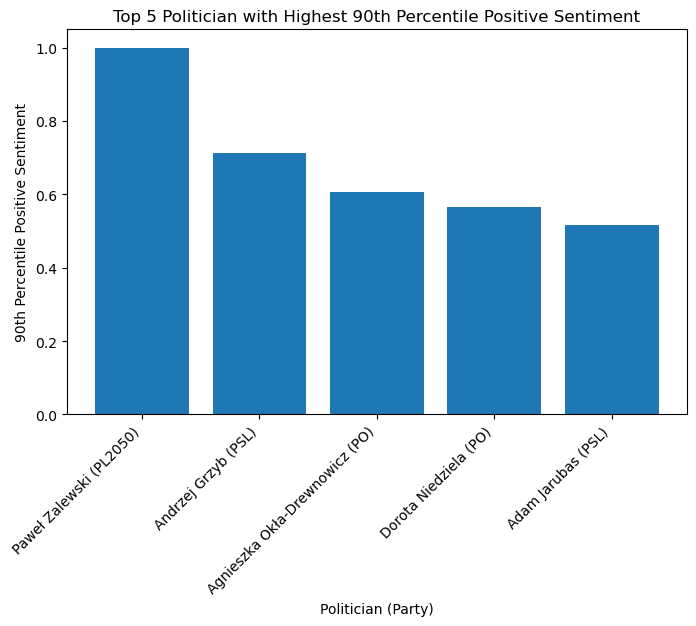

In [7]:
percentile_90_pos = df_no_na.groupby('username')['pos_vader'].quantile(0.90).reset_index()

top5_pos_sentiment = percentile_90_pos.sort_values(by='pos_vader', ascending=False).head(5)
top5_pos_sentiment = top5_pos_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_pos_sentiment['name_with_party'] = top5_pos_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_pos_sentiment['name_with_party'], top5_pos_sentiment["pos_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Positive Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Positive Sentiment')
plt.show()

According to the VADER analysis, the top 5 politicians with the highest 90th percentile of positive sentiment in their tweets include 2 individuals from PO, 2 from PSL, and 1 from PL2050.

### 4.3. Negative Sentiment on party level

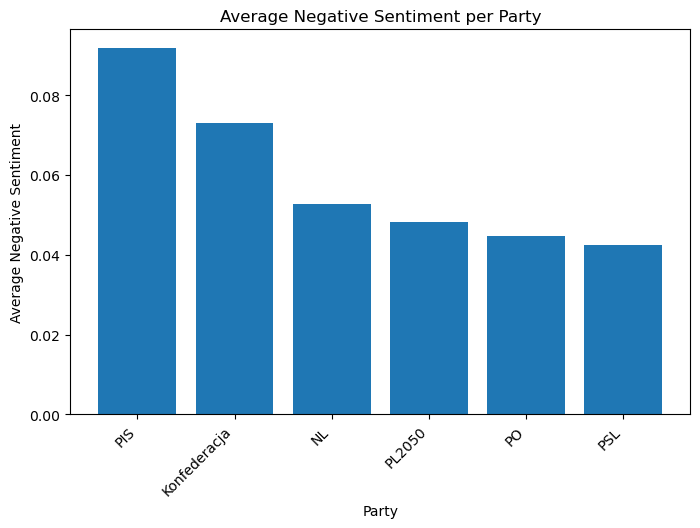

In [8]:
average_neg_sentiment_party = df_no_na.groupby('party')['neg_vader'].mean().reset_index()

top5_avg_neg_sentiment_party = average_neg_sentiment_party.sort_values(by='neg_vader', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_neg_sentiment_party['party'], top5_avg_neg_sentiment_party["neg_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Average Negative Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Negative Sentiment')
plt.show()


We can observe that the plot shows the highest average negative sentiment for PIS, followed closely by Konfederacja. The lowest average negative sentiment is observed for PO and PSL.

### 4.4. Positive Sentiment on party level

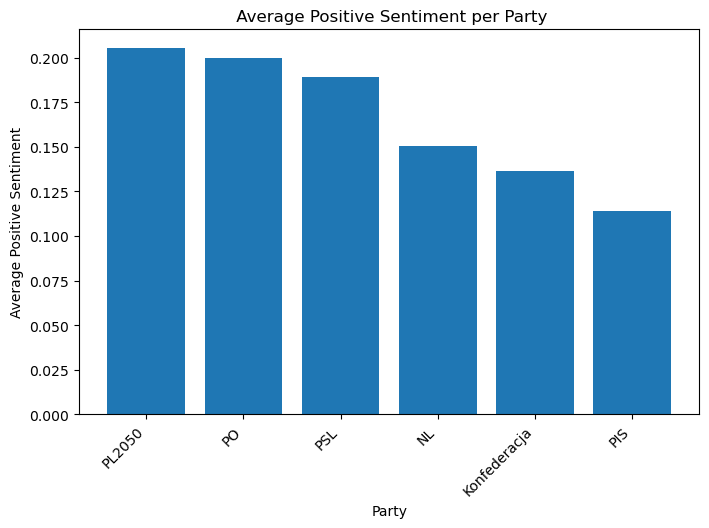

In [9]:
average_pos_sentiment_party = df_no_na.groupby('party')['pos_vader'].mean().reset_index()

top5_avg_pos_sentiment_party = average_pos_sentiment_party.sort_values(by='pos_vader', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_pos_sentiment_party['party'], top5_avg_pos_sentiment_party["pos_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title(' Average Positive Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Positive Sentiment')
plt.show()


We can observe that the plot is a rotated version of the previous plot. The highest average positive sentiment is for PL2050, PO, and PSL, while NL, Konfederacja, and PIS have lower scores.

### 4.5. Most Negative Tweets 

In [10]:
top_5_negative_tweets = df_no_na.nlargest(10, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
print("Top 5 Most Negative Tweets:")
print(top_5_negative_tweets)

Top 5 Most Negative Tweets:
                     name         party               text_clean_en  neg_vader
2759    Witold Tumanowicz  Konfederacja                         NO.      1.000
2764    Witold Tumanowicz  Konfederacja                         NO.      1.000
4243   Mateusz Morawiecki           PIS               Embarrassing.      1.000
6801        Michał Wójcik           PIS                    Shocking      1.000
7894    Izabela Leszczyna            PO                          NO      1.000
9842       Paweł Zalewski        PL2050                    Horrible      1.000
10668   Urszula Pasławska           PSL               Unfortunately      1.000
10971        Adam Jarubas           PSL                    Nonsense      1.000
8903     Dorota Niedziela            PO  Shamelessness and villainy      0.857
463    Włodzimierz Skalik  Konfederacja            Stupid question.      0.773


In [11]:
pd.set_option('display.max_colwidth', None)
df_no_na['word_count'] = df_no_na['text_clean_en'].apply(lambda x: len(str(x).split()))
df_no_na = df_no_na[df_no_na['word_count'] >= 3]
top_negative_posts = df_no_na.nlargest(10, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
print("Top 5 Most Negative Tweets (longer than 2 words):")
print(top_negative_posts)

Top 5 Most Negative Tweets (longer than 2 words):
                    name         party  \
8903    Dorota Niedziela            PO   
4557  Mateusz Morawiecki           PIS   
8840    Dorota Niedziela            PO   
3023   Witold Tumanowicz  Konfederacja   
6713       Michał Wójcik           PIS   
4650  Mateusz Morawiecki           PIS   
5616         Patryk Jaki           PIS   
7447  Antoni Macierewicz           PIS   
600   Włodzimierz Skalik  Konfederacja   
823   Włodzimierz Skalik  Konfederacja   

                                                    text_clean_en  neg_vader  
8903                                   Shamelessness and villainy      0.857  
4557                                                What a shame.      0.756  
8840         Search No. 2, The world of hatred, lies and villainy      0.681  
3023                             The Internet takes no prisoners!      0.659  
6713                             Nasty government with no future.      0.659  
4650         

We can observe that VADER was able to capture negative tweets. However, they were not as negative as expected. Without filtering the shortest tweets, the most negative tweets were simply "NO." After filtering to consider tweets longer than two words, the tweets were still not very negative or offensive.

### 4.6. Most Positive Tweets 

In [12]:
top_5_positive_tweets = df_no_na.nlargest(10, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
print("Top 5 Most Positive Tweets:")
print(top_5_positive_tweets)

Top 5 Most Positive Tweets:
                            name         party  \
1483            Sławomir Mentzen  Konfederacja   
1119            Sławomir Mentzen  Konfederacja   
9743        Katarzyna Pelczyńska        PL2050   
866           Włodzimierz Skalik  Konfederacja   
10831               Adam Jarubas           PSL   
8996            Dorota Niedziela            PO   
8449   Agnieszka Okła-Drewnowicz            PO   
10145              Andrzej Grzyb           PSL   
8424   Agnieszka Okła-Drewnowicz            PO   
5085                Beata Szydło           PIS   

                              text_clean_en  pos_vader  
1483            Congratulations! Good luck!      1.000  
1119         Congratulations and good luck!      0.910  
9743   Freedom, tolerance, mutual respect.       0.905  
866              God, thanks and greetings!      0.890  
10831       We strengthen security. Respect      0.886  
8996                     Happy Hallelujah 🐣      0.885  
8449                  

In [13]:
pd.set_option('display.max_colwidth', None)
df_no_na = df_no_na[df_no_na['word_count'] >= 10]
top_positive_posts = df_no_na.nlargest(10, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
print("Top 5 Most Positive Tweets (longer than 9 words):")
print(top_positive_posts)

Top 5 Most Positive Tweets (longer than 9 words):
                       name         party  \
8952       Dorota Niedziela            PO   
4159  Włodzimierz Czarzasty            NL   
1096       Sławomir Mentzen  Konfederacja   
8869       Dorota Niedziela            PO   
2064        Bartłomiej Pejo  Konfederacja   
8517      Izabela Leszczyna            PO   
7450     Antoni Macierewicz           PIS   
1900        Bartłomiej Pejo  Konfederacja   
9078       Dorota Niedziela            PO   
9623   Katarzyna Pelczyńska        PL2050   

                                                                                               text_clean_en  \
8952                                              Celebrating 🇵 🇱 🇵 🇱 🇵 🇱 🇵 🇱 #DzieńaflagiRP 🇵 🇱 🇵 🇱 🇵 🇱 🇵 🇱   
4159  #EuropeForYou The kind you dream about, the kind you want. Helpful, social, strong, safe, tolerant 😊     
1096               Congratulations! A great campaign and great commitment resulted in this very good result!   
8869  

VADER effectively captured positive tweets. Unlike negative tweets, unfiltered positive tweets are meaningful and often congratulatory. Tweets longer than 9 words are also related to celebrations, congratulations, and positive events.

### 4.7. Wordclouds

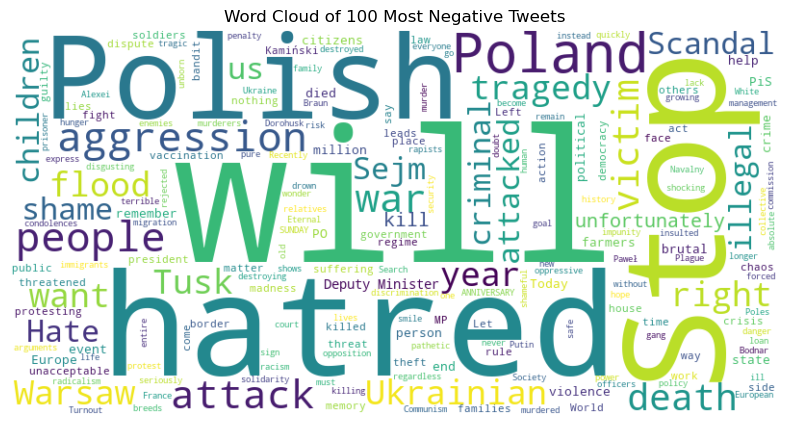

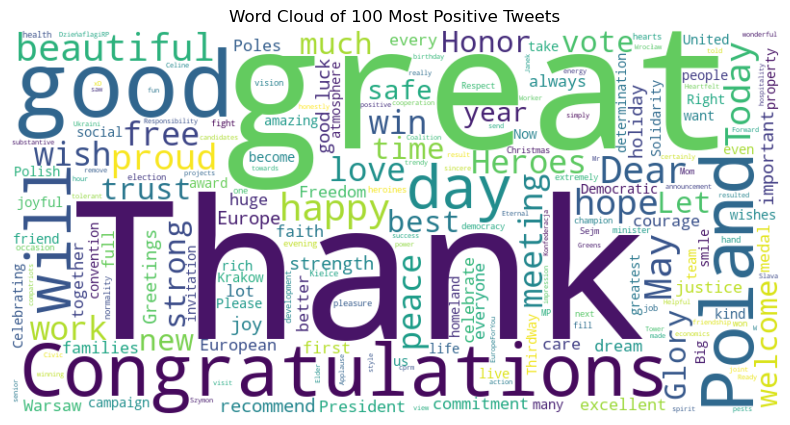

In [14]:
top_negative_posts = df_no_na.nlargest(100, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
negative_texts = ' '.join(top_negative_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Negative Tweets')
plt.show()

top_positive_posts = df_no_na.nlargest(100, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
negative_texts = ' '.join(top_positive_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Positive Tweets')
plt.show()

## 5. Supervised approach Sentiment Analysis (BERT)

In [15]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def bert_predict(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output[0][0].cpu().numpy()
    scores = softmax(scores)
    return scores

df_no_na['text_bert'] = df_no_na['text_clean_en_demojized'].apply(preprocess)
df_no_na[['negative_bert', 'neutral_bert', 'positive_bert']] = df_no_na['text_bert'].apply(lambda x: pd.Series(bert_predict(x), index=['negative', 'neutral', 'positive']))
df_no_na[["username", "name", "text_clean_en", "negative_bert", "neutral_bert", "positive_bert"]].head()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,username,name,text_clean_en,negative_bert,neutral_bert,positive_bert
0,Wlodek_Skalik,Włodzimierz Skalik,"""Not a step back!"" - you haven't put any forward either so far.",0.383399,0.542734,0.073867
1,Wlodek_Skalik,Włodzimierz Skalik,An unknown number just called me. I thought it was the doctor who wanted to ask about my well-being. It turned out that it was photovoltaics.,0.481302,0.484627,0.034071
2,Wlodek_Skalik,Włodzimierz Skalik,"Will ""even harder work"" translate into the fulfillment of at least some of the election promises you made?",0.484032,0.475687,0.040281
4,Wlodek_Skalik,Włodzimierz Skalik,"❌ A few days ago, I voted to dismiss Krzysztof Czabański from the position of member of the National Media Council. 👉 It is worth reminding how unequal the fight we fought during the last parliamentary elections. Apart from preventing the Confederation from accessing public media, it is difficult…",0.472890,0.511618,0.015491
5,Wlodek_Skalik,Włodzimierz Skalik,"🇵 🇱 Another term of #PO and once again they are trying to block the #IndependenceMarch. If they do not go with us, we will go in spite of them! Just don't extinguish the spirit!",0.751366,0.231580,0.017054


### 5.1. Top 5 most negative politicians

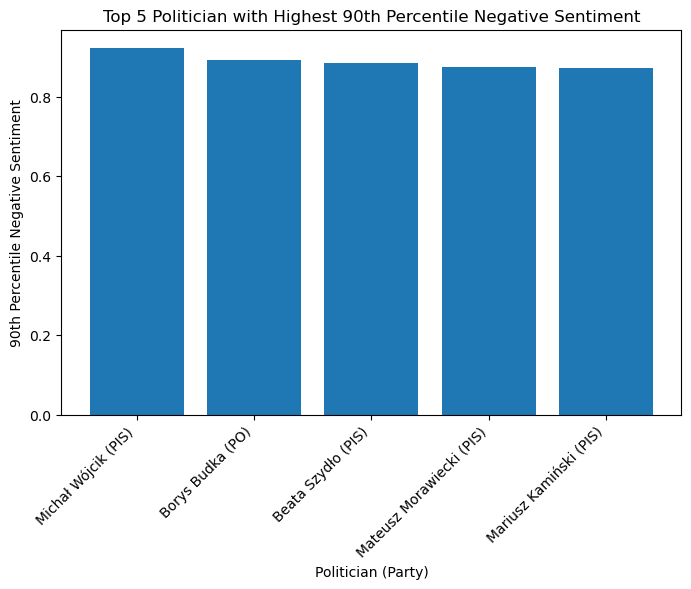

In [16]:
percentile_90_neg = df_no_na.groupby('username')['negative_bert'].quantile(0.90).reset_index()

top5_neg_sentiment = percentile_90_neg.sort_values(by='negative_bert', ascending=False).head(5)
top5_neg_sentiment = top5_neg_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_neg_sentiment['name_with_party'] = top5_neg_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_neg_sentiment['name_with_party'], top5_neg_sentiment["negative_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Negative Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Negative Sentiment')
plt.show()

We can observe that the 90th percentile Negative Sentiment scores are quite comparable among the top 5 politicians. Compared to the VADER method, the top 5 also include 4 politicians from PIS, but one individual from PO is present. Three politicians remain the same, while two have changed. This indicates a difference in predictions made by the VADER and BERT models.

### 5.2. Top 5 most positive politicians

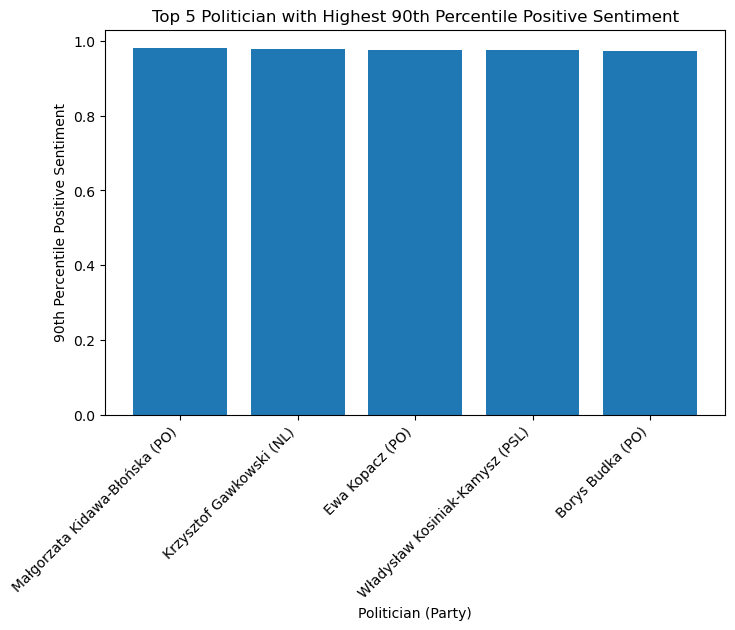

In [17]:
percentile_90_pos = df_no_na.groupby('username')['positive_bert'].quantile(0.90).reset_index()

top5_pos_sentiment = percentile_90_pos.sort_values(by='positive_bert', ascending=False).head(5)
top5_pos_sentiment = top5_pos_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_pos_sentiment['name_with_party'] = top5_pos_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_pos_sentiment['name_with_party'], top5_pos_sentiment["positive_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Positive Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Positive Sentiment')
plt.show()

We can observe that the 90th percentile Positive Sentiment scores are quite comparable among the top 5 politicians. Compared to the VADER method, there are some changes. Three politicians remain the same, while the top two positions have changed. This confirms a difference in predictions made by the VADER and BERT models.

### 5.3. Negative Sentiment on party level

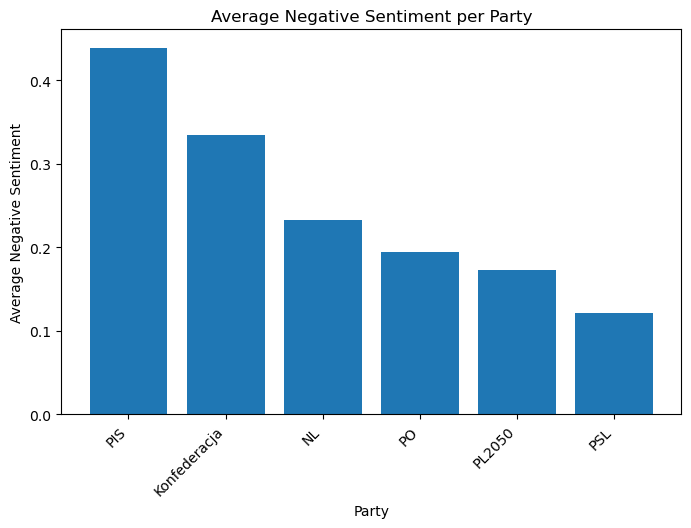

In [18]:
average_neg_sentiment_party = df_no_na.groupby('party')['negative_bert'].mean().reset_index()

top5_avg_neg_sentiment_party = average_neg_sentiment_party.sort_values(by='negative_bert', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_neg_sentiment_party['party'], top5_avg_neg_sentiment_party["negative_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Average Negative Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Negative Sentiment')
plt.show()


We can observe that the party rankings are quite similar to those obtained using the VADER method. The top three positions remain unchanged. However, the parties in the 4th and 5th positions have switched places.

### 5.4. Positive Sentiment on party level

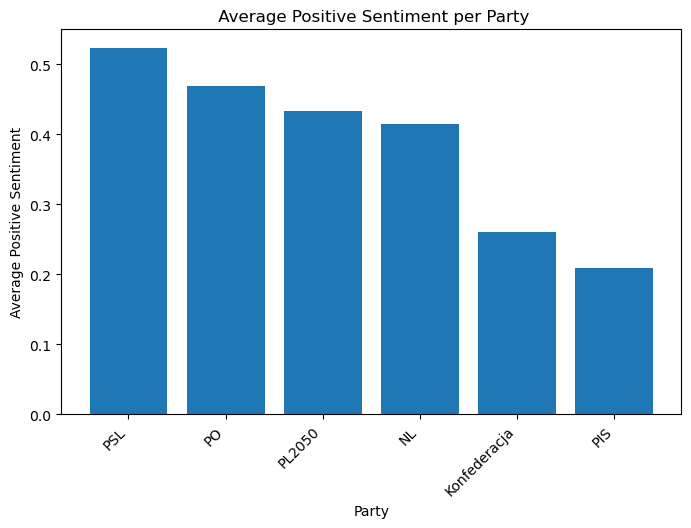

In [19]:
average_pos_sentiment_party = df_no_na.groupby('party')['positive_bert'].mean().reset_index()

top5_avg_pos_sentiment_party = average_pos_sentiment_party.sort_values(by='positive_bert', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_pos_sentiment_party['party'], top5_avg_pos_sentiment_party["positive_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title(' Average Positive Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Positive Sentiment')
plt.show()


The RoBERTa model indicated that the PSL party had the highest average positive sentiment, while the VADER method ranked PL2050 in the top position. In both cases, PO was predicted to be in second place. The last three positions remained consistent between the two models.

### 5.5. Most Negative Tweets 

In [20]:
top_5_negative_tweets = df_no_na.nlargest(10, 'negative_bert')[['name', 'party', 'text_clean_en', 'negative_bert']]
print("Top 5 Most Negative Tweets:")
print(top_5_negative_tweets)

Top 5 Most Negative Tweets:
                     name         party  \
6480        Michał Wójcik           PIS   
960      Sławomir Mentzen  Konfederacja   
6580        Michał Wójcik           PIS   
7236     Mariusz Kamiński           PIS   
5511          Patryk Jaki           PIS   
5758          Patryk Jaki           PIS   
6715        Michał Wójcik           PIS   
7252     Mariusz Kamiński           PIS   
4088  Krzysztof Gawkowski            NL   
6757        Michał Wójcik           PIS   

                                                                                                                                                                                                                                                                       text_clean_en  \
6480                                                                                                                                        The economy is sinking, the judiciary is sinking, and Polish science is also s

The RoBERTa model is able to identify more sophisticated negative tweets. Unlike VADER, which often predicts that the most negative tweets are single negative words, RoBERTa captures the nuanced meaning of the tweets. There is no need to filter out short tweets with only one word (e.g., "NO") as was necessary with VADER. These tweets are mostly critical of the actions of other parties, with the majority coming from PIS.

### 5.6. Most Positive Tweets 

In [21]:
top_5_positive_tweets = df_no_na.nlargest(10, 'positive_bert')[['name', 'party', 'text_clean_en', 'positive_bert']]
print("Top 5 Most Positive Tweets:")
print(top_5_positive_tweets)

Top 5 Most Positive Tweets:
                            name         party  \
7592                  Ewa Kopacz            PO   
10605  Władysław Kosiniak-Kamysz           PSL   
984             Sławomir Mentzen  Konfederacja   
3843              Robert Biedroń            NL   
4082         Krzysztof Gawkowski            NL   
974             Sławomir Mentzen  Konfederacja   
4432          Mateusz Morawiecki           PIS   
7986                 Borys Budka            PO   
9671        Katarzyna Pelczyńska        PL2050   
7953   Małgorzata Kidawa-Błońska            PO   

                                                                                                                                                        text_clean_en  \
7592                                                   A beautiful day and great hope that the dreams of many Polish families will come true. I am extremely touched!   
10605                                                                              

The most positive tweets from the RoBERTa model are more meaningful than those from the VADER method. They are notably longer and often reflect the authors' happiness following certain events, such as meetings with voters or positive election results.

### 5.7. Word clouds

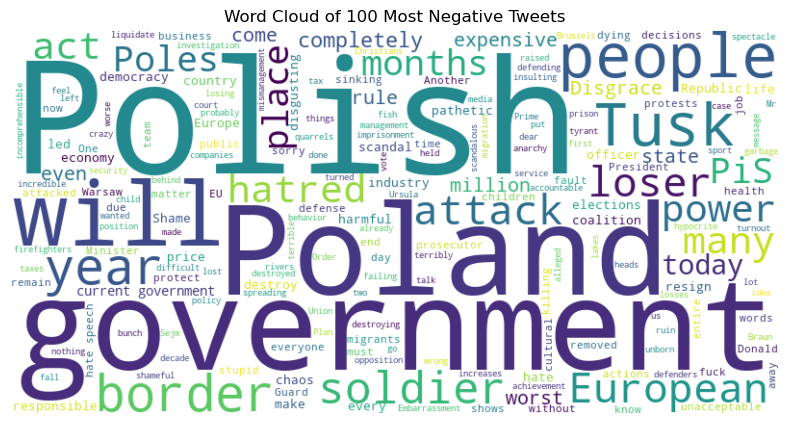

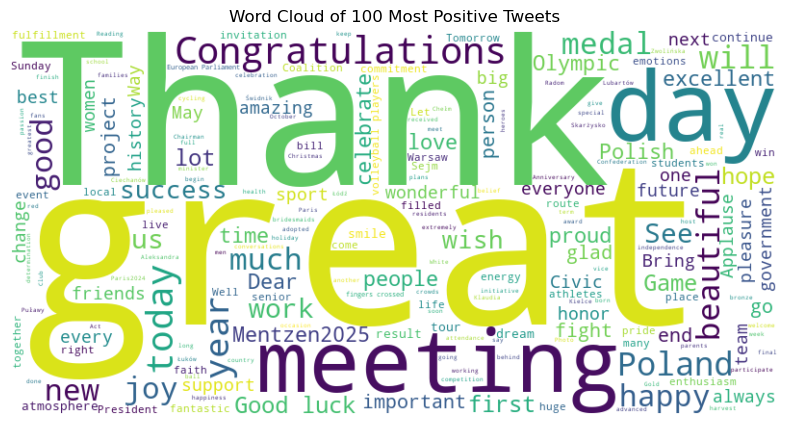

In [22]:
top_negative_posts = df_no_na.nlargest(100, 'negative_bert')[['name', 'party', 'text_clean_en', 'negative_bert']]
negative_texts = ' '.join(top_negative_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Negative Tweets')
plt.show()

top_positive_posts = df_no_na.nlargest(100, 'positive_bert')[['name', 'party', 'text_clean_en', 'positive_bert']]
negative_texts = ' '.join(top_positive_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Positive Tweets')
plt.show()

## 6. Conclusions

1. The RoBERTa model is able to identify more sophisticated negative tweets compared to VADER. While VADER often predicts that the most negative tweets are single negative words, RoBERTa captures the nuanced meaning of the tweets. There is no need to filter out short tweets with only one word (e.g., "NO") as was necessary with VADER. These tweets are mostly critical of the actions of other parties, with the majority coming from PIS.

2. The most positive tweets identified by the RoBERTa model are more meaningful than those from the VADER method. They are notably longer and often reflect the authors' happiness following certain events, such as meetings with voters or positive election results.

3. According to the VADER analysis, the top 5 politicians with the highest 90th percentile of negative sentiment in their tweets include 4 individuals from PIS and 1 from Konfederacja. In contrast, the RoBERTa model also includes 4 politicians from PIS but replaces one individual with a politician from PO. This indicates a difference in predictions made by the VADER and BERT models.

4. The 90th percentile Positive Sentiment scores are quite comparable among the top 5 politicians. However, there are some changes when comparing the VADER method to the RoBERTa model. Three politicians remain the same, while the top two positions have changed, confirming a difference in predictions made by the two models.

5. The party rankings for negative sentiment are quite similar between the VADER and RoBERTa methods. The top three positions remain unchanged, but the parties in the 4th and 5th positions have switched places.

6. The RoBERTa model indicates that the PSL party has the highest average positive sentiment, while the VADER method ranks PL2050 in the top position. In both cases, PO is predicted to be in second place, and the last three positions remain consistent between the two models.

7. RoBERTa model is harder to interpret because it does not assign pure weights to each word as VADER does. However, it can better detect the most positive and negative tweets, making them more meaningful and truly expressive of positive or negative emotions.

## 7. Refrences

[1] Hutto, C., & Gilbert, E. (2014). VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text. Proceedings of the International AAAI Conference on Web and Social Media, 8(1), 216–225. https://doi.org/10.1609/icwsm.v8i1.14550

[2] Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, and Veselin Stoyanov. 2019. Roberta: A robustly optimized bert pretraining approach. arXiv preprint arXiv:190711692.
